In [20]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
%run /home/datarian/git/master-thesis-code/notebooks/common_init.ipynb

Setup logging to file: out.log
Figure output directory saved in figure_output at /home/datarian/OneDrive/unine/Master_Thesis/ma-thesis-report/figures


In [22]:
%run /home/datarian/git/master-thesis-code/notebooks/learning_init.ipynb

Set plot_confusion_matrix and registered Rescaler()


In [23]:
%autoreload 2
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load custom code
import kdd98.data_handler as dh
from kdd98.config import Config
import pathlib
import pickle

In [24]:
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [25]:
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import ParameterGrid, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, make_scorer, log_loss, recall_score, roc_auc_score, balanced_accuracy_score, precision_score, classification_report, roc_curve, auc
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin

In [26]:
# Where to save the figures

CHAPTER_ID = "svm"
# Where to save the figures
IMAGES_PATH = pathlib.Path(figure_output/'learning')

pathlib.Path(IMAGES_PATH).mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension=["pdf", "png"], resolution=300):
    if tight_layout:
        plt.tight_layout()
    [plt.savefig(pathlib.Path(IMAGES_PATH, fig_id + "." + f), 
                 format=f,
                 dpi=resolution,
                 transparent=True,
                 bbox_inches='tight') for f in fig_extension]

In [27]:
with open(pathlib.Path(Config.get("df_store"), "X_train.pd.pkl"), "rb") as f:
    kdd98_learn_feat = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "y_train.pd.pkl"), "rb") as f:
    kdd98_learn_targets = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "X_test.pd.pkl"), "rb") as f:
    kdd98_test_feat = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "y_test.pd.pkl"), "rb") as f:
    kdd98_test_targets = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "X_train_all_relevant.pd.pkl"), "rb") as f:
    kdd98_learn_feat_all_relevant = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "X_test_all_relevant.pd.pkl"), "rb") as f:
    kdd98_test_feat_all_relevant = pickle.load(f)
    
# Extracting the data and resetting target to [-1, 1]
X_train = kdd98_learn_feat.values
X_train_all_relevant = kdd98_learn_feat_all_relevant.values
y_train = kdd98_learn_targets.loc[:,"TARGET_B"].astype("int64").values

X_test = kdd98_test_feat.values
X_test_all_relevant = kdd98_test_feat_all_relevant.values
y_test = kdd98_test_targets.loc[:,"TARGET_B"].astype("int64").values

In [11]:
class_weight = len(y_train[y_train == 0])/sum(y_train)

# Support Vector Machine

In [29]:
scaler = Rescaler(transformer="ftrans")
X_train_rescaled = scaler.fit_transform(X_train_all_relevant)
X_test_rescaled = scaler.transform(X_test_all_relevant)

In [83]:
svc = SVC(
    class_weight="balanced",
    kernel="poly",
    degree = 3,
    coef0=1,
    gamma="auto",
    random_state=Config.get("random_seed"),
    max_iter=1e6,
verbose=3)

In [ ]:
svc.fit(X_train_rescaled,y_train)

[LibSVM]

In [30]:
y_predict = svc.predict(X_test_rescaled)

NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
plot_confusion_matrix(y_test, y_predict, classes=[1,0], normalize=True)

In [17]:
param_grid = {
    "scaler__transformer": ["rtrans", "ftrans"],
    "svc__coef0": [1, 2, 5],
}

svc = SVC(
    class_weight="balanced",
    kernel="poly",
    degree=3,
    probability=True,
    gamma="auto",
    random_state=Config.get("random_seed"),
    max_iter=1e6,
verbose=3)

scaler = Rescaler()

svc_pipe = Pipeline([
    ("scaler", scaler),
    ("svc", svc)
])

scoring = {
    "ROC": make_scorer(roc_auc_score),
    "logloss": "neg_log_loss",
    "recall": make_scorer(recall_score)
}

In [18]:
gs_svc = GridSearchCV(
    svc_pipe,
    param_grid,
    scoring=scoring,
    n_jobs=-1,
    cv=5,
    refit="recall",
    verbose=10
)

In [19]:
gs_svc.fit(X_train_all_relevant,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 71.8min
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed: 77.1min remaining: 14.4min


AttributeError: predict_proba is not available when  probability=False

In [ ]:
import pickle
import pathlib
with open(pathlib.Path(Config.get("model_store"), "svc_gridsearch.pkl"), "wb") as f:
    pickle.dump(gs_svc, f)

In [ ]:
gs_svc.best_estimator_.get_params

In [ ]:
y_predict = gs_svc.best_estimator_.predict(X_test_all_relevant)

In [ ]:
plot_confusion_matrix(y_test, y_predict, classes=[1,0], normalize=True)

In [ ]:
classifier = gs_svc.best_estimator_

In [123]:
del gs_svc

In [25]:
y_predict = mlp.predict(X_test_rescaled)

In [27]:
print(pd.DataFrame(confusion_matrix(y_test, y_predict),
columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

     pred_neg  pred_pos
neg     17248       866
pos       859       110


Normalized confusion matrix
[[0.11351909 0.88648091]
 [0.04780833 0.95219167]]


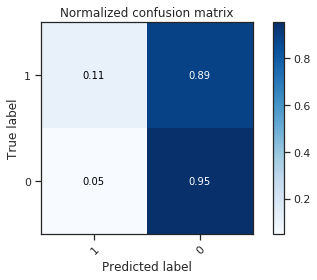

In [26]:
plot_confusion_matrix(y_test,y_predict, classes=[1,0], normalize=True)

In [ ]:
param_grid = {"alpha": 10.0 ** -np.arange(1, 7)}

roc = make_scorer(roc_auc_score)

scoring = {"ROC": make_scorer(roc_auc_score),
           "logloss": "neg_log_loss"}

In [ ]:
gs_mlp = GridSearchCV(
    mlp,
    param_grid,
    scoring= make_scorer(log_loss, labels = [0,1]),
    n_jobs=4,
    cv=5,
    refit="logloss",
    verbose=3
)

In [ ]:
gs_glm_logit.fit(X_rescaled, y_resampled)

In [ ]:
gs_glm_logit.best_estimator_.get_params

In [ ]:
y_predict = gs_glm_logit.best_estimator_.predict(X_test_rescaled)

In [ ]:
plot_confusion_matrix(y_test, y_predict, classes=[0,1])

In [ ]:
import pickle
import pathlib
with open(pathlib.Path(Config.get("model_store"), "glmnet_gridsearch.pkl"), "wb") as f:
    pickle.dump(gs_glm_logit, f)

In [ ]:
classifier = gs_glm_logit.best_estimator_

In [ ]:
importances = pd.DataFrame(gs_unbalanced_xgboost_boruta.best_estimator_.feature_importances_, index=kdd98_learn_feat_all_relevant.columns.values.tolist(), columns=["importance"])

In [ ]:
importances = importances.sort_values(by="importance", ascending=False)

In [ ]:
factor_importance = 100/importances.iloc[0,0]
factor_importance

In [ ]:
importances.importance = importances.importance.map(lambda i: i*factor_importance)

In [ ]:
most_important = importances.head(50)
most_important

In [ ]:
import seaborn as sns

In [ ]:
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(y=most_important.index, x=most_important.importance)
sns.despine(left=True, bottom=True)
ylabel("Relative importance")